<a href="https://colab.research.google.com/github/KoreTane/interesting/blob/main/AnaliseAnalise_2024_11_04_13_40_59.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pyspark

In [31]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import seaborn as sns
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.stat import Correlation


spark = SparkSession.builder \
    .appName("Olist Data Analysis") \
    .getOrCreate()


# Ler cada arquivo CSV diretamente
order_reviews = spark.read.option("header", "true").csv("order_reviews.csv")
product_category_name_translation = spark.read.option("header", "true").csv("product_category_name_translation.csv")
orders = spark.read.option("header", "true").csv("orders.csv")
sellers = spark.read.option("header", "true").csv("sellers.csv")
products = spark.read.option("header", "true").csv("products.csv")
customers = spark.read.option("header", "true").csv("customers.csv")
order_items = spark.read.option("header", "true").csv("order_items.csv")
order_payments = spark.read.option("header", "true").csv("order_payments.csv")
geolocation = spark.read.option("header", "true").csv("geolocation.csv")

# Exibindo os DataFrames
#display(order_reviews)
#display(product_category_name_translation)
#display(orders)
#display(sellers)
#display(products)
#display(customers)
#display(order_items)
#display(order_payments)
#display(geolocation)
# Definir o esquema do DataFrame para orders

In [3]:
display(order_items)

DataFrame[order_id: string, order_item_id: string, product_id: string, seller_id: string, shipping_limit_date: string, price: string, freight_value: string]

In [4]:
# Exibir as colunas de filtered_order_items
order_reviews.printSchema()
product_category_name_translation.printSchema()
orders.printSchema()
sellers.printSchema()
products.printSchema()
customers.printSchema()
order_items.printSchema()
order_payments.printSchema()
geolocation.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- review_score: string (nullable = true)
 |-- review_comment_title: string (nullable = true)
 |-- review_comment_message: string (nullable = true)
 |-- review_creation_date: string (nullable = true)
 |-- review_answer_timestamp: string (nullable = true)

root
 |-- product_category_name: string (nullable = true)
 |-- product_category_name_english: string (nullable = true)

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)

root
 |-- seller_id: string (nullable = true)
 |-- seller_zip_code_prefix: string (nullable = true)
 |-- seller_city

In [5]:
# Aplicando describe() em cada DataFrame
dataframes = {
    "Order Reviews": order_reviews,
    "Product Category Name Translation": product_category_name_translation,
    "Orders": orders,
    "Sellers": sellers,
    "Products": products,
    "Customers": customers,
    "Order Items": order_items,
    "Order Payments": order_payments,
    "Geolocation": geolocation
}

# Exibindo o resultado do describe() para cada DataFrame
for name, df3 in dataframes.items():
    print(f"Descriptive Statistics for {name}:")
    df3.describe().show(truncate=False)

Descriptive Statistics for Order Reviews:
+-------+------------------+-----------------------------------------+---------------------+--------------------+----------------------+------------------------------------------------------------------+-----------------------------------------------+
|summary|review_id         |order_id                                 |review_score         |review_comment_title|review_comment_message|review_creation_date                                              |review_answer_timestamp                        |
+-------+------------------+-----------------------------------------+---------------------+--------------------+----------------------+------------------------------------------------------------------+-----------------------------------------------+
|count  |104161            |101926                                   |101782               |12005               |41083                 |95398                                                             

In [6]:
# features engine de orders
# Converter colunas para o tipo date
orders = orders.withColumn('order_purchase_timestamp', col('order_purchase_timestamp').cast('timestamp'))
orders = orders.withColumn('order_approved_at', col('order_approved_at').cast('timestamp'))
orders = orders.withColumn('order_delivered_carrier_date', col('order_delivered_carrier_date').cast('timestamp'))
orders = orders.withColumn('order_delivered_customer_date', col('order_delivered_customer_date').cast('timestamp'))
orders = orders.withColumn('order_estimated_delivery_date', col('order_estimated_delivery_date').cast('timestamp'))

# Calcular durações e criar novas colunas
orders = orders.withColumn('days_to_approval', datediff(col('order_approved_at'), col('order_purchase_timestamp')))
orders = orders.withColumn('days_to_carrier', datediff(col('order_delivered_carrier_date'), col('order_purchase_timestamp')))
orders = orders.withColumn('days_to_delivery', datediff(col('order_delivered_customer_date'), col('order_purchase_timestamp')))
orders = orders.withColumn('days_estimated_vs_actual_delivery', datediff(col('order_delivered_customer_date'), col('order_estimated_delivery_date')))

# Mostrar as novas colunas
orders.select('days_to_approval', 'days_to_carrier', 'days_to_delivery', 'days_estimated_vs_actual_delivery').show()


+----------------+---------------+----------------+---------------------------------+
|days_to_approval|days_to_carrier|days_to_delivery|days_estimated_vs_actual_delivery|
+----------------+---------------+----------------+---------------------------------+
|               0|              2|               8|                               -8|
|               2|              2|              14|                               -6|
|               0|              0|               9|                              -18|
|               0|              4|              14|                              -13|
|               0|              1|               3|                              -10|
|               0|              2|              17|                               -6|
|               2|           NULL|            NULL|                             NULL|
|               0|              6|              10|                              -12|
|               2|              3|              10|   

In [7]:
    # Converter colunas para o tipo timestamp
    orders = orders.withColumn('order_approved_at', col('order_approved_at').cast('timestamp'))
    order_items = order_items.withColumn('shipping_limit_date', col('shipping_limit_date').cast('timestamp'))

    # Fazer o join entre as tabelas orders e order_items
    joined_df2 = order_items.join(orders, on='order_id')

    # Calcular a diferença em dias entre shipping_limit_date e order_approved_at
    joined_df2 = joined_df2.withColumn('days_to_shipping_limit', datediff(col('shipping_limit_date'), col('order_approved_at')))

    # Selecionar todas as colunas de order_items mais a coluna criada
    order_items = joined_df2.select('order_id', 'order_item_id', 'product_id', 'seller_id',
                                        'shipping_limit_date', 'price', 'freight_value',
                                        'days_to_shipping_limit')

    # Mostrar as novas colunas para verificar
    order_items.show()


+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+----------------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date| price|freight_value|days_to_shipping_limit|
+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+----------------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.90|        13.29|                     6|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.90|        19.93|                     7|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30|199.00|        17.87|                     4|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18| 12.99|        12.79|                     7|

In [8]:
# Iterando sobre cada DataFrame para contar valores nulos e duplicados
for table_name, df in dataframes.items():
    print(f"Análise da tabela: {table_name}")

    # Contar valores nulos em cada coluna
    null_counts = {column: df.filter(col(column).isNull()).count() for column in df.columns}

    # Contar duplicados
    duplicate_count = df.count() - df.distinct().count()

    # Exibir resultados
    print("Contagem de valores nulos por coluna:")
    for column, count in null_counts.items():
        print(f"  {column}: {count} nulos")

    print(f"Total de registros duplicados: {duplicate_count}\n")

Análise da tabela: Order Reviews
Contagem de valores nulos por coluna:
  review_id: 1 nulos
  order_id: 2236 nulos
  review_score: 2380 nulos
  review_comment_title: 92157 nulos
  review_comment_message: 63079 nulos
  review_creation_date: 8764 nulos
  review_answer_timestamp: 8785 nulos
Total de registros duplicados: 85

Análise da tabela: Product Category Name Translation
Contagem de valores nulos por coluna:
  product_category_name: 0 nulos
  product_category_name_english: 0 nulos
Total de registros duplicados: 0

Análise da tabela: Orders
Contagem de valores nulos por coluna:
  order_id: 0 nulos
  customer_id: 0 nulos
  order_status: 0 nulos
  order_purchase_timestamp: 0 nulos
  order_approved_at: 160 nulos
  order_delivered_carrier_date: 1783 nulos
  order_delivered_customer_date: 2965 nulos
  order_estimated_delivery_date: 0 nulos
Total de registros duplicados: 0

Análise da tabela: Sellers
Contagem de valores nulos por coluna:
  seller_id: 0 nulos
  seller_zip_code_prefix: 0 nul

In [9]:
# Realizando a junção entre os DataFrames
result_df = order_reviews.alias("r").join(
    orders.alias("o"),
    on="order_id",  # Junção com base na coluna order_id
    how="inner"     # Tipo de junção (inner join)
).groupBy(
    "r.review_score"  # Agrupando pelo review_score
).agg(
    F.count("r.review_id").alias("total_reviews"),            # Contando o número total de reviews
    F.count("r.review_comment_message").alias("total_comments"),  # Contando o número total de comentários
    F.count("r.review_comment_title").alias("total_comment_titles")  # Contando o número total de títulos de comentários
).orderBy(
    "r.review_score"  # Ordenando pelo review_score
)

# Exibindo o resultado
result_df.show()

+------------+-------------+--------------+--------------------+
|review_score|total_reviews|total_comments|total_comment_titles|
+------------+-------------+--------------+--------------------+
|           1|        11424|          8745|                1873|
|           2|         3151|          2145|                 478|
|           3|         8179|          3557|                 824|
|           4|        19142|          5976|                1735|
|           5|        57328|         20554|                6658|
+------------+-------------+--------------+--------------------+



In [10]:
# Definição da segmentação por Necessidade do Consumidor
segmentacoes_necessidade = { "beleza_saude": "Higiene Pessoal", "informatica_acessorios": "Tecnologia e Acessórios", "automotivo": "Automóveis e Ferramentas", "cama_mesa_banho": "Casa e Decoração", "moveis_decoracao": "Casa e Decoração", "esporte_lazer": "Esporte e Lazer", "perfumaria": "Higiene Pessoal", "utilidades_domesticas": "Casa e Decoração", "telefonia": "Tecnologia e Acessórios", "relogios_presentes": "Moda e Acessórios", "alimentos_bebidas": "Alimentação e Bebidas", "bebes": "Infantil", "papelaria": "Trabalho e Estudo", "tablets_impressao_imagem": "Tecnologia e Acessórios", "brinquedos": "Infantil", "telefonia_fixa": "Tecnologia e Acessórios", "ferramentas_jardim": "Automóveis e Ferramentas", "fashion_bolsas_e_acessorios": "Moda e Acessórios", "eletroportateis": "Casa e Decoração", "consoles_games": "Entretenimento", "audio": "Entretenimento", "fashion_calcados": "Moda e Acessórios", "cool_stuff": "Entretenimento", "malas_acessorios": "Moda e Acessórios", "climatizacao": "Casa e Decoração", "construcao_ferramentas_construcao": "Automóveis e Ferramentas", "moveis_cozinha_area_de_servico_jantar_e_jardim": "Casa e Decoração", "construcao_ferramentas_jardim": "Automóveis e Ferramentas", "fashion_roupa_masculina": "Moda e Acessórios", "pet_shop": "Animais de Estimação", "moveis_escritorio": "Casa e Decoração", "market_place": "Serviços e Outros", "eletronicos": "Tecnologia e Acessórios", "eletrodomesticos": "Casa e Decoração", "artigos_de_festas": "Entretenimento", "casa_conforto": "Casa e Decoração", "construcao_ferramentas_ferramentas": "Automóveis e Ferramentas", "agro_industria_e_comercio": "Automóveis e Ferramentas", "moveis_colchao_e_estofado": "Casa e Decoração", "livros_tecnicos": "Trabalho e Estudo", "casa_construcao": "Automóveis e Ferramentas", "instrumentos_musicais": "Entretenimento", "moveis_sala": "Casa e Decoração", "construcao_ferramentas_iluminacao": "Automóveis e Ferramentas", "industria_comercio_e_negocios": "Trabalho e Estudo", "alimentos": "Alimentação e Bebidas", "artes": "Entretenimento", "moveis_quarto": "Casa e Decoração", "livros_interesse_geral": "Entretenimento", "construcao_ferramentas_seguranca": "Automóveis e Ferramentas", "fashion_underwear_e_moda_praia": "Moda e Acessórios", "fashion_esporte": "Moda e Acessórios", "sinalizacao_e_seguranca": "Automóveis e Ferramentas", "pcs": "Tecnologia e Acessórios", "artigos_de_natal": "Entretenimento", "fashion_roupa_feminina": "Moda e Acessórios", "eletrodomesticos_2": "Casa e Decoração", "livros_importados": "Entretenimento", "bebidas": "Alimentação e Bebidas", "cine_foto": "Entretenimento", "la_cuisine": "Casa e Decoração", "musica": "Entretenimento", "casa_conforto_2": "Casa e Decoração", "portateis_casa_forno_e_cafe": "Casa e Decoração", "cds_dvds_musicais": "Entretenimento", "dvds_blu_ray": "Entretenimento", "flores": "Moda e Acessórios", "artes_e_artesanato": "Entretenimento", "fraldas_higiene": "Infantil", "fashion_roupa_infanto_juvenil": "Infantil", "seguros_e_servicos": "Serviços e Outros" }

# Criação de uma função UDF para mapear as segmentações
def segmentacoe_necessidade(categoria):
    return segmentacoes_necessidade.get(categoria, "Necessidades")

segmentacoe_necessidade_udf = udf(segmentacoe_necessidade, StringType())

# Adição da coluna de segmentação de sentimento ao DataFrame
products = products.withColumn(
    "segmentacao_necessidade",
    segmentacoe_necessidade_udf(col("product_category_name"))
)

In [11]:
# Definição da segmentação de sentimento
segmentacoes = {
    "beleza_saude": "Satisfação Alta",
    "informatica_acessorios": "Misto",
    "automotivo": "Satisfação Alta",
    "cama_mesa_banho": "Neutro",
    "moveis_decoracao": "Satisfação Alta",
    "esporte_lazer": "Satisfação Alta",
    "perfumaria": "Satisfação Alta",
    "utilidades_domesticas": "Neutro",
    "telefonia": "Misto",
    "relogios_presentes": "Satisfação Alta",
    "alimentos_bebidas": "Satisfação Alta",
    "bebes": "Satisfação Alta",
    "papelaria": "Neutro",
    "tablets_impressao_imagem": "Misto",
    "brinquedos": "Satisfação Alta",
    "telefonia_fixa": "Neutro",
    "ferramentas_jardim": "Satisfação Alta",
    "fashion_bolsas_e_acessorios": "Satisfação Alta",
    "eletroportateis": "Neutro",
    "consoles_games": "Satisfação Alta",
    "audio": "Satisfação Alta",
    "fashion_calcados": "Misto",
    "cool_stuff": "Satisfação Alta",
    "malas_acessorios": "Satisfação Alta",
    "climatizacao": "Neutro",
    "construcao_ferramentas_construcao": "Satisfação Alta",
    "moveis_cozinha_area_de_servico_jantar_e_jardim": "Satisfação Alta",
    "construcao_ferramentas_jardim": "Satisfação Alta",
    "fashion_roupa_masculina": "Misto",
    "pet_shop": "Satisfação Alta",
    "moveis_escritorio": "Satisfação Alta",
    "market_place": "Neutro",
    "eletronicos": "Misto",
    "eletrodomesticos": "Neutro",
    "artigos_de_festas": "Satisfação Alta",
    "casa_conforto": "Satisfação Alta",
    "construcao_ferramentas_ferramentas": "Satisfação Alta",
    "agro_industria_e_comercio": "Satisfação Alta",
    "moveis_colchao_e_estofado": "Satisfação Alta",
    "livros_tecnicos": "Misto",
    "casa_construcao": "Satisfação Alta",
    "instrumentos_musicais": "Satisfação Alta",
    "moveis_sala": "Satisfação Alta",
    "construcao_ferramentas_iluminacao": "Satisfação Alta",
    "industria_comercio_e_negocios": "Satisfação Alta",
    "alimentos": "Satisfação Alta",
    "artes": "Satisfação Alta",
    "moveis_quarto": "Satisfação Alta",
    "livros_interesse_geral": "Misto",
    "construcao_ferramentas_seguranca": "Satisfação Alta",
    "fashion_underwear_e_moda_praia": "Satisfação Alta",
    "fashion_esporte": "Satisfação Alta",
    "sinalizacao_e_seguranca": "Neutro",
    "pcs": "Neutro",
    "artigos_de_natal": "Satisfação Alta",
    "fashion_roupa_feminina": "Misto",
    "eletrodomesticos_2": "Neutro",
    "livros_importados": "Misto",
    "bebidas": "Satisfação Alta",
    "cine_foto": "Satisfação Alta",
    "la_cuisine": "Satisfação Alta",
    "musica": "Satisfação Alta",
    "casa_conforto_2": "Satisfação Alta",
    "portateis_casa_forno_e_cafe": "Satisfação Alta",
    "cds_dvds_musicais": "Satisfação Alta",
    "dvds_blu_ray": "Satisfação Alta",
    "flores": "Satisfação Alta",
    "artes_e_artesanato": "Satisfação Alta",
    "fraldas_higiene": "Satisfação Alta",
    "fashion_roupa_infanto_juvenil": "Satisfação Alta",
    "seguros_e_servicos": "Neutro"
}

# Criação de uma função UDF para mapear as segmentações
def segmentacao_sentimento(categoria):
    return segmentacoes.get(categoria, "Neutro")

segmentacao_udf = udf(segmentacao_sentimento, StringType())

# Adição da coluna de segmentação de sentimento ao DataFrame
products = products.withColumn(
    "segmentacao_sentimento",
    segmentacao_udf(col("product_category_name"))
)


In [12]:
# Definição da segmentação por tipo
# Definição da segmentação por tipo
segmentacoes_tipo = { "beleza_saude": "Uso Pessoal",
                     "informatica_acessorios": "Reposição",
                     "automotivo": "Reposição",
                     "cama_mesa_banho": "Uso Pessoal",
                     "moveis_decoracao": "Decorativo",
                     "esporte_lazer": "Esportivo",
                     "perfumaria": "Uso Pessoal",
                     "utilidades_domesticas": "Reposição",
                     "telefonia": "Reposição",
                     "relogios_presentes": "Presente",
                     "alimentos_bebidas": "Reposição",
                     "bebes": "Uso Pessoal",
                     "papelaria": "Educacional",
                     "tablets_impressao_imagem": "Reposição",
                     "brinquedos": "Presente",
                     "telefonia_fixa": "Reposição",
                     "ferramentas_jardim": "Reposição",
                     "fashion_bolsas_e_acessorios": "Presente",
                     "eletroportateis": "Reposição",
                     "consoles_games": "Presente",
                     "audio": "Uso Pessoal",
                     "fashion_calcados": "Uso Pessoal",
                     "cool_stuff": "Presente",
                     "malas_acessorios": "Presente",
                     "climatizacao": "Reposição",
                     "construcao_ferramentas_construcao": "Reposição",
                     "moveis_cozinha_area_de_servico_jantar_e_jardim": "Decorativo",
                     "construcao_ferramentas_jardim": "Reposição",
                     "fashion_roupa_masculina": "Uso Pessoal",
                     "pet_shop": "Reposição",
                     "moveis_escritorio": "Reposição",
                     "market_place": "Uso Pessoal",
                     "eletronicos": "Reposição",
                     "eletrodomesticos": "Reposição",
                     "artigos_de_festas": "Presente",
                     "casa_conforto": "Decorativo",
                     "construcao_ferramentas_ferramentas": "Reposição",
                     "agro_industria_e_comercio": "Reposição",
                     "moveis_colchao_e_estofado": "Decorativo",
                     "livros_tecnicos": "Educacional",
                     "casa_construcao": "Reposição",
                     "instrumentos_musicais": "Uso Pessoal",
                     "moveis_sala": "Decorativo",
                     "construcao_ferramentas_iluminacao": "Reposição",
                     "industria_comercio_e_negocios": "Reposição",
                     "alimentos": "Reposição",
                     "artes": "Uso Pessoal",
                     "moveis_quarto": "Decorativo",
                     "livros_interesse_geral": "Educacional",
                     "construcao_ferramentas_seguranca": "Reposição",
                     "fashion_underwear_e_moda_praia": "Uso Pessoal",
                     "fashion_esporte": "Uso Pessoal",
                     "sinalizacao_e_seguranca": "Reposição",
                     "pcs": "Reposição",
                     "artigos_de_natal": "Presente",
                     "fashion_roupa_feminina": "Uso Pessoal",
                     "eletrodomesticos_2": "Reposição",
                     "livros_importados": "Educacional",
                     "bebidas": "Reposição",
                     "cine_foto": "Uso Pessoal",
                     "la_cuisine": "Decorativo",
                     "musica": "Uso Pessoal",
                     "casa_conforto_2": "Decorativo",
                     "portateis_casa_forno_e_cafe": "Reposição",
                     "cds_dvds_musicais": "Uso Pessoal",
                     "dvds_blu_ray": "Uso Pessoal",
                     "flores": "Presente",
                     "artes_e_artesanato": "Uso Pessoal",
                     "fraldas_higiene": "Reposição",
                     "fashion_roupa_infanto_juvenil": "Uso Pessoal",
                     "seguros_e_servicos": "Uso Pessoal" }

# Criação de uma função UDF para mapear as segmentações de tipo
def segmentacao_tipo(categoria):
    return segmentacoes_tipo.get(categoria, "Uso Pessoal")

segmentacao_tipo_udf = udf(segmentacao_tipo, StringType())

# Adição da coluna de segmentação de tipo ao DataFrame
products = products.withColumn(
    "segmentacao_tipo",
    segmentacao_tipo_udf(col("product_category_name"))
)

In [13]:
# Definição da segmentação por validade
segmentacoes_validade = {
    "beleza_saude": "Média Duração",
    "informatica_acessorios": "Longa Duração",
    "automotivo": "Longa Duração",
    "cama_mesa_banho": "Média Duração",
    "moveis_decoracao": "Longa Duração",
    "esporte_lazer": "Média Duração",
    "perfumaria": "Longa Duração",
    "utilidades_domesticas": "Longa Duração",
    "telefonia": "Longa Duração",
    "relogios_presentes": "Longa Duração",
    "alimentos_bebidas": "Curta Duração",
    "bebes": "Curta Duração",
    "papelaria": "Média Duração",
    "tablets_impressao_imagem": "Longa Duração",
    "brinquedos": "Média Duração",
    "telefonia_fixa": "Longa Duração",
    "ferramentas_jardim": "Longa Duração",
    "fashion_bolsas_e_acessorios": "Longa Duração",
    "eletroportateis": "Média Duração",
    "consoles_games": "Longa Duração",
    "audio": "Longa Duração",
    "fashion_calcados": "Média Duração",
    "cool_stuff": "Longa Duração",
    "malas_acessorios": "Longa Duração",
    "climatizacao": "Longa Duração",
    "construcao_ferramentas_construcao": "Longa Duração",
    "moveis_cozinha_area_de_servico_jantar_e_jardim": "Longa Duração",
    "construcao_ferramentas_jardim": "Longa Duração",
    "fashion_roupa_masculina": "Média Duração",
    "pet_shop": "Média Duração",
    "moveis_escritorio": "Longa Duração",
    "market_place": "Não Perecíveis",
    "eletronicos": "Longa Duração",
    "eletrodomesticos": "Longa Duração",
    "artigos_de_festas": "Média Duração",
    "casa_conforto": "Longa Duração",
    "construcao_ferramentas_ferramentas": "Longa Duração",
    "agro_industria_e_comercio": "Longa Duração",
    "moveis_colchao_e_estofado": "Longa Duração",
    "livros_tecnicos": "Não Perecíveis",
    "casa_construcao": "Longa Duração",
    "instrumentos_musicais": "Não Perecíveis",
    "moveis_sala": "Longa Duração",
    "construcao_ferramentas_iluminacao": "Longa Duração",
    "industria_comercio_e_negocios": "Longa Duração",
    "alimentos": "Curta Duração",
    "artes": "Não Perecíveis",
    "moveis_quarto": "Longa Duração",
    "livros_interesse_geral": "Não Perecíveis",
    "construcao_ferramentas_seguranca": "Longa Duração",
    "fashion_underwear_e_moda_praia": "Média Duração",
    "fashion_esporte": "Média Duração",
    "sinalizacao_e_seguranca": "Longa Duração",
    "pcs": "Longa Duração",
    "artigos_de_natal": "Média Duração",
    "fashion_roupa_feminina": "Média Duração",
    "eletrodomesticos_2": "Longa Duração",
    "livros_importados": "Não Perecíveis",
    "bebidas": "Curta Duração",
    "cine_foto": "Longa Duração",
    "la_cuisine": "Longa Duração",
    "musica": "Longa Duração",
    "casa_conforto_2": "Longa Duração",
    "portateis_casa_forno_e_cafe": "Longa Duração",
    "cds_dvds_musicais": "Longa Duração",
    "dvds_blu_ray": "Longa Duração",
    "flores": "Curta Duração",
    "artes_e_artesanato": "Não Perecíveis",
    "fraldas_higiene": "Curta Duração",
    "fashion_roupa_infanto_juvenil": "Média Duração",
    "seguros_e_servicos": "Não Perecíveis"
}

# Criação de uma função UDF para mapear as segmentações de validade
def segmentacao_validade(categoria):
    return segmentacoes_validade.get(categoria, "Não Perecíveis")

segmentacao_validade_udf = udf(segmentacao_validade, StringType())

# Adição da coluna de segmentação de validade ao DataFrame
products = products.withColumn(
    "segmentacao_validade",
    segmentacao_validade_udf(col("product_category_name"))
)


In [14]:
# Definição da segmentação por Utilização Principal
segmentacoes_utilizacao = {
    "beleza_saude": "Uso Diário",
    "informatica_acessorios": "Trabalho",
    "automotivo": "Trabalho",
    "cama_mesa_banho": "Uso Diário",
    "moveis_decoracao": "Lazer",
    "esporte_lazer": "Lazer",
    "perfumaria": "Uso Diário",
    "utilidades_domesticas": "Uso Diário",
    "telefonia": "Trabalho",
    "relogios_presentes": "Presente",
    "alimentos_bebidas": "Uso Diário",
    "bebes": "Uso Diário",
    "papelaria": "Trabalho",
    "tablets_impressao_imagem": "Trabalho",
    "brinquedos": "Lazer",
    "telefonia_fixa": "Trabalho",
    "ferramentas_jardim": "Trabalho",
    "fashion_bolsas_e_acessorios": "Uso Diário",
    "eletroportateis": "Uso Diário",
    "consoles_games": "Lazer",
    "audio": "Lazer",
    "fashion_calcados": "Uso Diário",
    "cool_stuff": "Lazer",
    "malas_acessorios": "Viagem",
    "climatizacao": "Uso Diário",
    "construcao_ferramentas_construcao": "Trabalho",
    "moveis_cozinha_area_de_servico_jantar_e_jardim": "Uso Diário",
    "construcao_ferramentas_jardim": "Trabalho",
    "fashion_roupa_masculina": "Uso Diário",
    "pet_shop": "Uso Diário",
    "moveis_escritorio": "Trabalho",
    "market_place": "Trabalho",
    "eletronicos": "Trabalho",
    "eletrodomesticos": "Uso Diário",
    "artigos_de_festas": "Lazer",
    "casa_conforto": "Uso Diário",
    "construcao_ferramentas_ferramentas": "Trabalho",
    "agro_industria_e_comercio": "Trabalho",
    "moveis_colchao_e_estofado": "Uso Diário",
    "livros_tecnicos": "Educação",
    "casa_construcao": "Trabalho",
    "instrumentos_musicais": "Lazer",
    "moveis_sala": "Uso Diário",
    "construcao_ferramentas_iluminacao": "Trabalho",
    "industria_comercio_e_negocios": "Trabalho",
    "alimentos": "Uso Diário",
    "artes": "Lazer",
    "moveis_quarto": "Uso Diário",
    "livros_interesse_geral": "Educação",
    "construcao_ferramentas_seguranca": "Trabalho",
    "fashion_underwear_e_moda_praia": "Uso Diário",
    "fashion_esporte": "Lazer",
    "sinalizacao_e_seguranca": "Trabalho",
    "pcs": "Trabalho",
    "artigos_de_natal": "Lazer",
    "fashion_roupa_feminina": "Uso Diário",
    "eletrodomesticos_2": "Uso Diário",
    "livros_importados": "Educação",
    "bebidas": "Uso Diário",
    "cine_foto": "Lazer",
    "la_cuisine": "Uso Diário",
    "musica": "Lazer",
    "casa_conforto_2": "Uso Diário",
    "portateis_casa_forno_e_cafe": "Uso Diário",
    "cds_dvds_musicais": "Lazer",
    "dvds_blu_ray": "Lazer",
    "flores": "Presente",
    "artes_e_artesanato": "Lazer",
    "fraldas_higiene": "Uso Diário",
    "fashion_roupa_infanto_juvenil": "Uso Diário",
    "seguros_e_servicos": "Trabalho"
}

# Criação de uma função UDF para mapear as segmentações de utilização principal
def segmentacao_utilizacao(categoria):
    return segmentacoes_utilizacao.get(categoria, "Uso Diário")

segmentacao_utilizacao_udf = udf(segmentacao_utilizacao, StringType())

# Adição da coluna de segmentação de utilização principal ao DataFrame
products = products.withColumn(
    "segmentacao_utilizacao",
    segmentacao_utilizacao_udf(col("product_category_name"))
)


In [15]:
# Definição da segmentação por Funcionalidade Principal
segmentacoes_funcionalidade = {
    "beleza_saude": "Conforto",
    "informatica_acessorios": "Trabalho",
    "automotivo": "Especializado",
    "cama_mesa_banho": "Essencial",
    "moveis_decoracao": "Conforto",
    "esporte_lazer": "Entretenimento",
    "perfumaria": "Conforto",
    "utilidades_domesticas": "Essencial",
    "telefonia": "Trabalho",
    "relogios_presentes": "Conforto",
    "alimentos_bebidas": "Essencial",
    "bebes": "Essencial",
    "papelaria": "Trabalho",
    "tablets_impressao_imagem": "Trabalho",
    "brinquedos": "Entretenimento",
    "telefonia_fixa": "Trabalho",
    "ferramentas_jardim": "Especializado",
    "fashion_bolsas_e_acessorios": "Conforto",
    "eletroportateis": "Essencial",
    "consoles_games": "Entretenimento",
    "audio": "Entretenimento",
    "fashion_calcados": "Conforto",
    "cool_stuff": "Entretenimento",
    "malas_acessorios": "Conforto",
    "climatizacao": "Essencial",
    "construcao_ferramentas_construcao": "Especializado",
    "moveis_cozinha_area_de_servico_jantar_e_jardim": "Essencial",
    "construcao_ferramentas_jardim": "Especializado",
    "fashion_roupa_masculina": "Conforto",
    "pet_shop": "Essencial",
    "moveis_escritorio": "Trabalho",
    "market_place": "Trabalho",
    "eletronicos": "Trabalho",
    "eletrodomesticos": "Essencial",
    "artigos_de_festas": "Entretenimento",
    "casa_conforto": "Conforto",
    "construcao_ferramentas_ferramentas": "Especializado",
    "agro_industria_e_comercio": "Especializado",
    "moveis_colchao_e_estofado": "Conforto",
    "livros_tecnicos": "Trabalho",
    "casa_construcao": "Especializado",
    "instrumentos_musicais": "Entretenimento",
    "moveis_sala": "Conforto",
    "construcao_ferramentas_iluminacao": "Especializado",
    "industria_comercio_e_negocios": "Especializado",
    "alimentos": "Essencial",
    "artes": "Entretenimento",
    "moveis_quarto": "Conforto",
    "livros_interesse_geral": "Entretenimento",
    "construcao_ferramentas_seguranca": "Especializado",
    "fashion_underwear_e_moda_praia": "Conforto",
    "fashion_esporte": "Conforto",
    "sinalizacao_e_seguranca": "Especializado",
    "pcs": "Trabalho",
    "artigos_de_natal": "Entretenimento",
    "fashion_roupa_feminina": "Conforto",
    "eletrodomesticos_2": "Essencial",
    "livros_importados": "Entretenimento",
    "bebidas": "Essencial",
    "cine_foto": "Entretenimento",
    "la_cuisine": "Essencial",
    "musica": "Entretenimento",
    "casa_conforto_2": "Conforto",
    "portateis_casa_forno_e_cafe": "Essencial",
    "cds_dvds_musicais": "Entretenimento",
    "dvds_blu_ray": "Entretenimento",
    "flores": "Conforto",
    "artes_e_artesanato": "Entretenimento",
    "fraldas_higiene": "Essencial",
    "fashion_roupa_infanto_juvenil": "Conforto",
    "seguros_e_servicos": "Especializado"
}

# Criação de uma função UDF para mapear as segmentações de funcionalidade principal
def segmentacao_funcionalidade(categoria):
    return segmentacoes_funcionalidade.get(categoria, "Essencial")

# Registro da UDF
segmentacao_funcionalidade_udf = udf(segmentacao_funcionalidade, StringType())

# Adição da coluna de segmentação de validade ao DataFrame
products = products.withColumn(
    "segmentacoes_funcionalidade",
    segmentacao_funcionalidade_udf(col("product_category_name"))
)

In [16]:
# Definição da segmentação por Nível de Interatividade
segmentacoes_interatividade = {
    "beleza_saude": "Média Interatividade",
    "informatica_acessorios": "Alta Interatividade",
    "automotivo": "Média Interatividade",
    "cama_mesa_banho": "Baixa Interatividade",
    "moveis_decoracao": "Baixa Interatividade",
    "esporte_lazer": "Alta Interatividade",
    "perfumaria": "Média Interatividade",
    "utilidades_domesticas": "Média Interatividade",
    "telefonia": "Alta Interatividade",
    "relogios_presentes": "Baixa Interatividade",
    "alimentos_bebidas": "Baixa Interatividade",
    "bebes": "Média Interatividade",
    "papelaria": "Média Interatividade",
    "tablets_impressao_imagem": "Alta Interatividade",
    "brinquedos": "Alta Interatividade",
    "telefonia_fixa": "Alta Interatividade",
    "ferramentas_jardim": "Média Interatividade",
    "fashion_bolsas_e_acessorios": "Baixa Interatividade",
    "eletroportateis": "Média Interatividade",
    "consoles_games": "Alta Interatividade",
    "audio": "Alta Interatividade",
    "fashion_calcados": "Baixa Interatividade",
    "cool_stuff": "Alta Interatividade",
    "malas_acessorios": "Baixa Interatividade",
    "climatizacao": "Média Interatividade",
    "construcao_ferramentas_construcao": "Média Interatividade",
    "moveis_cozinha_area_de_servico_jantar_e_jardim": "Baixa Interatividade",
    "construcao_ferramentas_jardim": "Média Interatividade",
    "fashion_roupa_masculina": "Baixa Interatividade",
    "pet_shop": "Média Interatividade",
    "moveis_escritorio": "Baixa Interatividade",
    "market_place": "Média Interatividade",
    "eletronicos": "Alta Interatividade",
    "eletrodomesticos": "Média Interatividade",
    "artigos_de_festas": "Média Interatividade",
    "casa_conforto": "Baixa Interatividade",
    "construcao_ferramentas_ferramentas": "Média Interatividade",
    "agro_industria_e_comercio": "Média Interatividade",
    "moveis_colchao_e_estofado": "Baixa Interatividade",
    "livros_tecnicos": "Média Interatividade",
    "casa_construcao": "Média Interatividade",
    "instrumentos_musicais": "Alta Interatividade",
    "moveis_sala": "Baixa Interatividade",
    "construcao_ferramentas_iluminacao": "Média Interatividade",
    "industria_comercio_e_negocios": "Média Interatividade",
    "alimentos": "Baixa Interatividade",
    "artes": "Alta Interatividade",
    "moveis_quarto": "Baixa Interatividade",
    "livros_interesse_geral": "Baixa Interatividade",
    "construcao_ferramentas_seguranca": "Média Interatividade",
    "fashion_underwear_e_moda_praia": "Baixa Interatividade",
    "fashion_esporte": "Alta Interatividade",
    "sinalizacao_e_seguranca": "Média Interatividade",
    "pcs": "Alta Interatividade",
    "artigos_de_natal": "Média Interatividade",
    "fashion_roupa_feminina": "Baixa Interatividade",
    "eletrodomesticos_2": "Média Interatividade",
    "livros_importados": "Baixa Interatividade",
    "bebidas": "Baixa Interatividade",
    "cine_foto": "Alta Interatividade",
    "la_cuisine": "Média Interatividade",
    "musica": "Alta Interatividade",
    "casa_conforto_2": "Baixa Interatividade",
    "portateis_casa_forno_e_cafe": "Média Interatividade",
    "cds_dvds_musicais": "Alta Interatividade",
    "dvds_blu_ray": "Alta Interatividade",
    "flores": "Baixa Interatividade",
    "artes_e_artesanato": "Alta Interatividade",
    "fraldas_higiene": "Média Interatividade",
    "fashion_roupa_infanto_juvenil": "Baixa Interatividade",
    "seguros_e_servicos": "Média Interatividade"
}
# Criação de uma função UDF para mapear as segmentações de funcionalidade principal
def segmentacao_interatividade(categoria):
    return segmentacoes_interatividade.get(categoria, "Média Interatividade")

# Registro da UDF
segmentacao_interatividade_udf = udf(segmentacao_interatividade, StringType())

# Adição da coluna de segmentação de validade ao DataFrame
products = products.withColumn(
    "segmentacao_interatividade",
    segmentacao_interatividade_udf(col("product_category_name"))
)


In [17]:
# Definição da segmentação por Impacto Ambiental
segmentacoes_impacto_ambiental = {
    "beleza_saude": "Médio",
    "informatica_acessorios": "Alto",
    "automotivo": "Alto",
    "cama_mesa_banho": "Baixo",
    "moveis_decoracao": "Médio",
    "esporte_lazer": "Médio",
    "perfumaria": "Médio",
    "utilidades_domesticas": "Médio",
    "telefonia": "Alto",
    "relogios_presentes": "Baixo",
    "alimentos_bebidas": "Baixo",
    "bebes": "Baixo",
    "papelaria": "Baixo",
    "tablets_impressao_imagem": "Alto",
    "brinquedos": "Médio",
    "telefonia_fixa": "Alto",
    "ferramentas_jardim": "Médio",
    "fashion_bolsas_e_acessorios": "Médio",
    "eletroportateis": "Alto",
    "consoles_games": "Alto",
    "audio": "Alto",
    "fashion_calcados": "Médio",
    "cool_stuff": "Alto",
    "malas_acessorios": "Médio",
    "climatizacao": "Alto",
    "construcao_ferramentas_construcao": "Alto",
    "moveis_cozinha_area_de_servico_jantar_e_jardim": "Baixo",
    "construcao_ferramentas_jardim": "Alto",
    "fashion_roupa_masculina": "Baixo",
    "pet_shop": "Baixo",
    "moveis_escritorio": "Médio",
    "market_place": "Médio",
    "eletronicos": "Alto",
    "eletrodomesticos": "Alto",
    "artigos_de_festas": "Baixo",
    "casa_conforto": "Baixo",
    "construcao_ferramentas_ferramentas": "Alto",
    "agro_industria_e_comercio": "Alto",
    "moveis_colchao_e_estofado": "Médio",
    "livros_tecnicos": "Baixo",
    "casa_construcao": "Alto",
    "instrumentos_musicais": "Médio",
    "moveis_sala": "Médio",
    "construcao_ferramentas_iluminacao": "Alto",
    "industria_comercio_e_negocios": "Alto",
    "alimentos": "Baixo",
    "artes": "Baixo",
    "moveis_quarto": "Médio",
    "livros_interesse_geral": "Baixo",
    "construcao_ferramentas_seguranca": "Alto",
    "fashion_underwear_e_moda_praia": "Baixo",
    "fashion_esporte": "Baixo",
    "sinalizacao_e_seguranca": "Alto",
    "pcs": "Alto",
    "artigos_de_natal": "Baixo",
    "fashion_roupa_feminina": "Baixo",
    "eletrodomesticos_2": "Alto",
    "livros_importados": "Baixo",
    "bebidas": "Baixo",
    "cine_foto": "Alto",
    "la_cuisine": "Baixo",
    "musica": "Baixo",
    "casa_conforto_2": "Baixo",
    "portateis_casa_forno_e_cafe": "Baixo",
    "cds_dvds_musicais": "Baixo",
    "dvds_blu_ray": "Baixo",
    "flores": "Baixo",
    "artes_e_artesanato": "Baixo",
    "fraldas_higiene": "Baixo",
    "fashion_roupa_infanto_juvenil": "Baixo",
    "seguros_e_servicos": "Baixo"
}

# Criação de uma função UDF para mapear as segmentações de funcionalidade principal
def segmentacoe_impacto_ambiental(categoria):
    return segmentacoes_impacto_ambiental.get(categoria, "Média Ambiental")

# Registro da UDF
segmentacoe_impacto_ambiental_udf = udf(segmentacoe_impacto_ambiental, StringType())

# Adição da coluna de segmentação de validade ao DataFrame
products = products.withColumn(
    "segmentacoes_impacto_ambiental",
    segmentacoe_impacto_ambiental_udf(col("product_category_name"))
)


In [18]:
# Definição da segmentação por Interação Humana Necessária
segmentacoes_interacao_humana = {
    "beleza_saude": "Manual",
    "informatica_acessorios": "Assistido",
    "automotivo": "Assistido",
    "cama_mesa_banho": "Manual",
    "moveis_decoracao": "Manual",
    "esporte_lazer": "Manual",
    "perfumaria": "Manual",
    "utilidades_domesticas": "Assistido",
    "telefonia": "Assistido",
    "relogios_presentes": "Manual",
    "alimentos_bebidas": "Manual",
    "bebes": "Manual",
    "papelaria": "Manual",
    "tablets_impressao_imagem": "Assistido",
    "brinquedos": "Manual",
    "telefonia_fixa": "Assistido",
    "ferramentas_jardim": "Manual",
    "fashion_bolsas_e_acessorios": "Manual",
    "eletroportateis": "Assistido",
    "consoles_games": "Assistido",
    "audio": "Assistido",
    "fashion_calcados": "Manual",
    "cool_stuff": "Assistido",
    "malas_acessorios": "Manual",
    "climatizacao": "Assistido",
    "construcao_ferramentas_construcao": "Manual",
    "moveis_cozinha_area_de_servico_jantar_e_jardim": "Manual",
    "construcao_ferramentas_jardim": "Manual",
    "fashion_roupa_masculina": "Manual",
    "pet_shop": "Manual",
    "moveis_escritorio": "Manual",
    "market_place": "Assistido",
    "eletronicos": "Assistido",
    "eletrodomesticos": "Assistido",
    "artigos_de_festas": "Manual",
    "casa_conforto": "Manual",
    "construcao_ferramentas_ferramentas": "Manual",
    "agro_industria_e_comercio": "Assistido",
    "moveis_colchao_e_estofado": "Manual",
    "livros_tecnicos": "Manual",
    "casa_construcao": "Manual",
    "instrumentos_musicais": "Manual",
    "moveis_sala": "Manual",
    "construcao_ferramentas_iluminacao": "Manual",
    "industria_comercio_e_negocios": "Assistido",
    "alimentos": "Manual",
    "artes": "Manual",
    "moveis_quarto": "Manual",
    "livros_interesse_geral": "Manual",
    "construcao_ferramentas_seguranca": "Assistido",
    "fashion_underwear_e_moda_praia": "Manual",
    "fashion_esporte": "Manual",
    "sinalizacao_e_seguranca": "Assistido",
    "pcs": "Assistido",
    "artigos_de_natal": "Manual",
    "fashion_roupa_feminina": "Manual",
    "eletrodomesticos_2": "Assistido",
    "livros_importados": "Manual",
    "bebidas": "Manual",
    "cine_foto": "Assistido",
    "la_cuisine": "Manual",
    "musica": "Manual",
    "casa_conforto_2": "Manual",
    "portateis_casa_forno_e_cafe": "Assistido",
    "cds_dvds_musicais": "Manual",
    "dvds_blu_ray": "Manual",
    "flores": "Manual",
    "artes_e_artesanato": "Manual",
    "fraldas_higiene": "Manual",
    "fashion_roupa_infanto_juvenil": "Manual",
    "seguros_e_servicos": "Assistido"
}

# Criação de uma função UDF para mapear as segmentações de funcionalidade principal
def segmentacoe_interacao_humana(categoria):
    return segmentacoes_interacao_humana.get(categoria, "Interação Humana")

# Registro da UDF
segmentacoe_interacao_humana_udf = udf(segmentacoe_interacao_humana, StringType())

# Adição da coluna de segmentação de validade ao DataFrame
products = products.withColumn(
    "segmentacoes_interacao_humana",
    segmentacoe_interacao_humana_udf(col("product_category_name"))
)

In [19]:
product_category_name_translation.describe()

DataFrame[summary: string, product_category_name: string, product_category_name_english: string]

In [20]:
# Unir as tabelas com base no order_id usando PySpark
merged_data = orders.join(order_payments, on='order_id', how='inner')

# Calcular o valor total por consumidor
total_per_consumer = merged_data.groupBy('customer_id').agg(F.sum('payment_value').alias('total_value'))

# Calcular Q1, Q3 e IQR
Q1 = total_per_consumer.approxQuantile('total_value', [0.10], 0.01)[0]
Q3 = total_per_consumer.approxQuantile('total_value', [0.90], 0.01)[0]
IQR = Q3 - Q1

# Definir limites inferior e superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar os consumidores que estão dentro dos limites
valid_customers = total_per_consumer.filter((F.col('total_value') >= lower_bound) & (F.col('total_value') <= upper_bound)).select('customer_id')

# Filtrar as tabelas orders e order_payments para remover os outliers
filtered_orders = orders.join(valid_customers, on='customer_id', how='inner')
filtered_order_payments = order_payments.join(filtered_orders.select('order_id'), on='order_id', how='inner')

# Exibir o número de registros removidos
removed_orders_count = orders.count() - filtered_orders.count()
removed_payments_count = order_payments.count() - filtered_order_payments.count()

print(f"Número de pedidos removidos: {removed_orders_count}")
print(f"Número de pagamentos removidos: {removed_payments_count}")

# Se necessário, você pode sobrescrever os DataFrames originais com os filtrados
orders = filtered_orders
order_payments = filtered_order_payments

Número de pedidos removidos: 2572
Número de pagamentos removidos: 2719


In [21]:
# 1. Unir as tabelas orders e order_items com base no order_id
merged_data = orders.join(order_items, on='order_id', how='inner')

# 2. Agrupar por customer_id e contar o número de produtos distintos (product_id) comprados por cada consumidor
product_count_per_customer = merged_data.groupBy('customer_id').agg(
    F.countDistinct('product_id').alias('distinct_product_count')  # Contar produtos distintos
)

# 3. Filtrar consumidores que compraram mais de um produto
customers_with_multiple_products = product_count_per_customer.filter(
    F.col('distinct_product_count') > 1
)

# 4. Contar quantos consumidores compraram mais de um produto
number_of_customers = customers_with_multiple_products.count()

print(f"Número de consumidores que compraram mais de um product_id: {number_of_customers}")

Número de consumidores que compraram mais de um product_id: 3115


In [22]:

# Join entre order_items e products para obter todas as informações necessárias
final_order_items = order_items.join(products, on='product_id')

# Aplicar StringIndexer nas colunas de segmentação
categorical_cols = [
    'segmentacao_necessidade', 'segmentacao_sentimento',
    'segmentacao_tipo', 'segmentacao_validade',
    'segmentacao_utilizacao', 'segmentacoes_funcionalidade',
    'segmentacao_interatividade', 'segmentacoes_impacto_ambiental',
    'segmentacoes_interacao_humana'
]

# Verificar se as colunas existem após o join
final_order_items_cols = final_order_items.columns
print("Columns in final_order_items after join:", final_order_items_cols)

# Filtrar apenas as colunas de segmentação que existem no DataFrame final_order_items
categorical_cols = [col for col in categorical_cols if col in final_order_items_cols]

# Índice de String
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]

# Construir o pipeline
pipeline = Pipeline(stages=indexers)

# Ajustar e transformar os dados
final_order_items = pipeline.fit(final_order_items).transform(final_order_items)

# Selecionar as colunas finais
selected_cols = ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
                 'price', 'freight_value', 'days_to_shipping_limit'] + [col + "_index" for col in categorical_cols]

final_order_items = final_order_items.select(selected_cols)

# Visualizar o DataFrame atualizado
final_order_items.show()


Columns in final_order_items after join: ['product_id', 'order_id', 'order_item_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'days_to_shipping_limit', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'segmentacao_necessidade', 'segmentacao_sentimento', 'segmentacao_tipo', 'segmentacao_validade', 'segmentacao_utilizacao', 'segmentacoes_funcionalidade', 'segmentacao_interatividade', 'segmentacoes_impacto_ambiental', 'segmentacoes_interacao_humana']
+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+----------------------+-----------------------------+----------------------------+----------------------+--------------------------+----------------------------+---------------------------------+--------------------------------+------------------------------------+----------

In [23]:
merged_data.describe()

DataFrame[summary: string, order_id: string, customer_id: string, order_status: string, days_to_approval: string, days_to_carrier: string, days_to_delivery: string, days_estimated_vs_actual_delivery: string, order_item_id: string, product_id: string, seller_id: string, price: string, freight_value: string, days_to_shipping_limit: string]

In [24]:
# Definir os indexers para os DataFrames corretos
indexers_orders = [
    StringIndexer(inputCol="order_status", outputCol="order_status_index"),
]

indexers_sellers = [
    StringIndexer(inputCol="seller_city", outputCol="seller_city_index"),
    StringIndexer(inputCol="seller_state", outputCol="seller_state_index"),
]

indexers_customers = [
    StringIndexer(inputCol="customer_state", outputCol="customer_state_index"),
]

indexers_payments = [
    StringIndexer(inputCol="payment_type", outputCol="payment_type_index"),
]

# Aplicar os indexers para orders
for indexer in indexers_orders:
    output_col = indexer.getOutputCol()
    if output_col in orders.columns:
        orders = orders.drop(output_col)
    orders = indexer.fit(orders).transform(orders)

# Aplicar os indexers para sellers
for indexer in indexers_sellers:
    output_col = indexer.getOutputCol()
    if output_col in sellers.columns:
        sellers = sellers.drop(output_col)
    sellers = indexer.fit(sellers).transform(sellers)

# Aplicar os indexers para customers
for indexer in indexers_customers:
    output_col = indexer.getOutputCol()
    if output_col in customers.columns:
        customers = customers.drop(output_col)
    customers = indexer.fit(customers).transform(customers)

# Aplicar os indexers para order_payments
for indexer in indexers_payments:
    output_col = indexer.getOutputCol()
    if output_col in order_payments.columns:
        order_payments = order_payments.drop(output_col)
    order_payments = indexer.fit(order_payments).transform(order_payments)

# Selecionar mês da order_purchase_timestamp
orders = orders.withColumn('order_purchase_month', month(col('order_purchase_timestamp')))

# Join entre order_items e products para obter as categorias dos produtos
order_items = order_items.join(products, on='product_id', how='inner')

# Transformar colunas categóricas de produtos
categorical_cols_products = [
    'segmentacao_necessidade', 'segmentacao_sentimento',
    'segmentacao_tipo', 'segmentacao_validade',
    'segmentacao_utilizacao', 'segmentacoes_funcionalidade',
    'segmentacao_interatividade', 'segmentacoes_impacto_ambiental',
    'segmentacoes_interacao_humana'
]

indexers_products = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols_products]
pipeline_products = Pipeline(stages=indexers_products)
products = pipeline_products.fit(products).transform(products)

# Join entre order_items e products com colunas transformadas
order_items = order_items.join(products, on='product_id', how='inner')

# Consolidar todas as features selecionadas com inner joins
df = order_reviews.select('order_id', col('review_score').cast('int').alias('target')) \
    .join(orders.select('order_id', 'customer_id', 'order_status_index', 'order_purchase_month',
                        'days_to_approval', 'days_to_carrier',
                        'days_to_delivery', 'days_estimated_vs_actual_delivery'),
          on='order_id', how='inner') \
    .join(order_items.select('order_id', 'product_id', 'price', 'freight_value', 'seller_id',
                             *[col + "_index" for col in categorical_cols_products]), on='order_id', how='inner') \
    .join(sellers.select('seller_id', 'seller_city_index', 'seller_state_index'), on='seller_id', how='inner') \
    .join(customers.select('customer_id', 'customer_state_index'), on='customer_id', how='inner') \
    .join(order_payments.select('order_id', 'payment_sequential', 'payment_type_index',
                                 'payment_installments', 'payment_value'), on='order_id', how='inner')

# Selecionar apenas as colunas necessárias para o modelo, incluindo novas colunas de duração
df = df.select('target', 'order_status_index', 'order_purchase_month',
               'days_to_approval', 'days_to_carrier',
               'days_to_delivery', 'days_estimated_vs_actual_delivery',
               'price', 'freight_value',
               'segmentacao_necessidade_index',
               'segmentacao_sentimento_index',
               'segmentacao_tipo_index',
               'segmentacao_validade_index',
               'segmentacao_utilizacao_index',
               'segmentacoes_funcionalidade_index',
               'segmentacao_interatividade_index',
               'segmentacoes_impacto_ambiental_index',
               'segmentacoes_interacao_humana_index',
               'seller_city_index',
               'seller_state_index',
               'customer_state_index',
               'payment_sequential',
               'payment_type_index',
               'payment_installments',
               'payment_value')

# Filtrar apenas linhas onde a coluna target (review_score) não é nula
df = df.filter(df.target.isNotNull())

# Tratar valores nulos (se necessário)
df = df.na.drop()  # Remove linhas com qualquer valor nulo (se ainda houver)

# Visualizar o DataFrame consolidado
df.show()

# Contar o número de linhas no DataFrame filtrado
num_linhas_df = df.count()
print(f"Número de linhas no DataFrame filtrado: {num_linhas_df}")

+------+------------------+--------------------+----------------+---------------+----------------+---------------------------------+------+-------------+-----------------------------+----------------------------+----------------------+--------------------------+----------------------------+---------------------------------+--------------------------------+------------------------------------+-----------------------------------+-----------------+------------------+--------------------+------------------+------------------+--------------------+-------------+
|target|order_status_index|order_purchase_month|days_to_approval|days_to_carrier|days_to_delivery|days_estimated_vs_actual_delivery| price|freight_value|segmentacao_necessidade_index|segmentacao_sentimento_index|segmentacao_tipo_index|segmentacao_validade_index|segmentacao_utilizacao_index|segmentacoes_funcionalidade_index|segmentacao_interatividade_index|segmentacoes_impacto_ambiental_index|segmentacoes_interacao_humana_index|seller

In [25]:
# Converter colunas para os tipos corretos
df = df.withColumn("price", col("price").cast("double"))
df = df.withColumn("freight_value", col("freight_value").cast("double"))
df = df.withColumn("payment_sequential", col("payment_sequential").cast("integer"))
df = df.withColumn("payment_installments", col("payment_installments").cast("integer"))
df = df.withColumn("payment_value", col("payment_value").cast("double")) # Mostrar o esquema atualizado
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- order_status_index: double (nullable = false)
 |-- order_purchase_month: integer (nullable = true)
 |-- days_to_approval: integer (nullable = true)
 |-- days_to_carrier: integer (nullable = true)
 |-- days_to_delivery: integer (nullable = true)
 |-- days_estimated_vs_actual_delivery: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- segmentacao_necessidade_index: double (nullable = false)
 |-- segmentacao_sentimento_index: double (nullable = false)
 |-- segmentacao_tipo_index: double (nullable = false)
 |-- segmentacao_validade_index: double (nullable = false)
 |-- segmentacao_utilizacao_index: double (nullable = false)
 |-- segmentacoes_funcionalidade_index: double (nullable = false)
 |-- segmentacao_interatividade_index: double (nullable = false)
 |-- segmentacoes_impacto_ambiental_index: double (nullable = false)
 |-- segmentacoes_interacao_humana_index: double (nullable =

In [32]:
# Selecionar as colunas que queremos normalizar
numeric_cols = ['price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value']

# Montar o VectorAssembler para combinar todas as colunas numéricas em uma única coluna "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")

# Aplicar o assembler ao DataFrame
df_assembled = assembler.transform(df)

# Inicializar o MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Ajustar o scaler ao DataFrame e transformar os dados
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Selecionar as colunas normalizadas e expandidas
scaled_df = df_scaled.select("scaled_features").rdd.map(lambda row: row.scaled_features.toArray().tolist()).toDF(numeric_cols)

# Adicionar a coluna target de volta ao DataFrame
final_df = df_scaled.select("target").join(scaled_df)

# Converter o DataFrame Spark para Pandas para visualização
df_pandas = final_df.toPandas()

# Calcular a matriz de correlação
correlation_matrix = df_pandas.corr()

# Configurar o tamanho da figura
plt.figure(figsize=(15, 10))

# Plotar a matriz de correlação usando seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Título do gráfico
plt.title('Matriz de Correlação (Dados Normalizados)')

# Exibir o gráfico
plt.show()


Py4JJavaError: An error occurred while calling o2247.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 688.0 failed 1 times, most recent failure: Lost task 1.0 in stage 688.0 (TID 691) (6d7fe4ac1292 executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:61)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:348)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$2(SparkPlan.scala:368)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$2$adapted(SparkPlan.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2759/0x00000008411f0840.apply(Unknown Source)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.allocateNewChunkIfNeeded(ChunkedByteBufferOutputStream.scala:87)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.write(ChunkedByteBufferOutputStream.scala:75)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:519)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:391)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2749/0x00000008411e7040.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.RDD$$Lambda$2746/0x00000008411d6040.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2701/0x000000084119a040.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:61)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:348)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$2(SparkPlan.scala:368)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$2$adapted(SparkPlan.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2759/0x00000008411f0840.apply(Unknown Source)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.allocateNewChunkIfNeeded(ChunkedByteBufferOutputStream.scala:87)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.write(ChunkedByteBufferOutputStream.scala:75)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:519)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:391)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2749/0x00000008411e7040.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.RDD$$Lambda$2746/0x00000008411d6040.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2701/0x000000084119a040.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [ ]:
' '

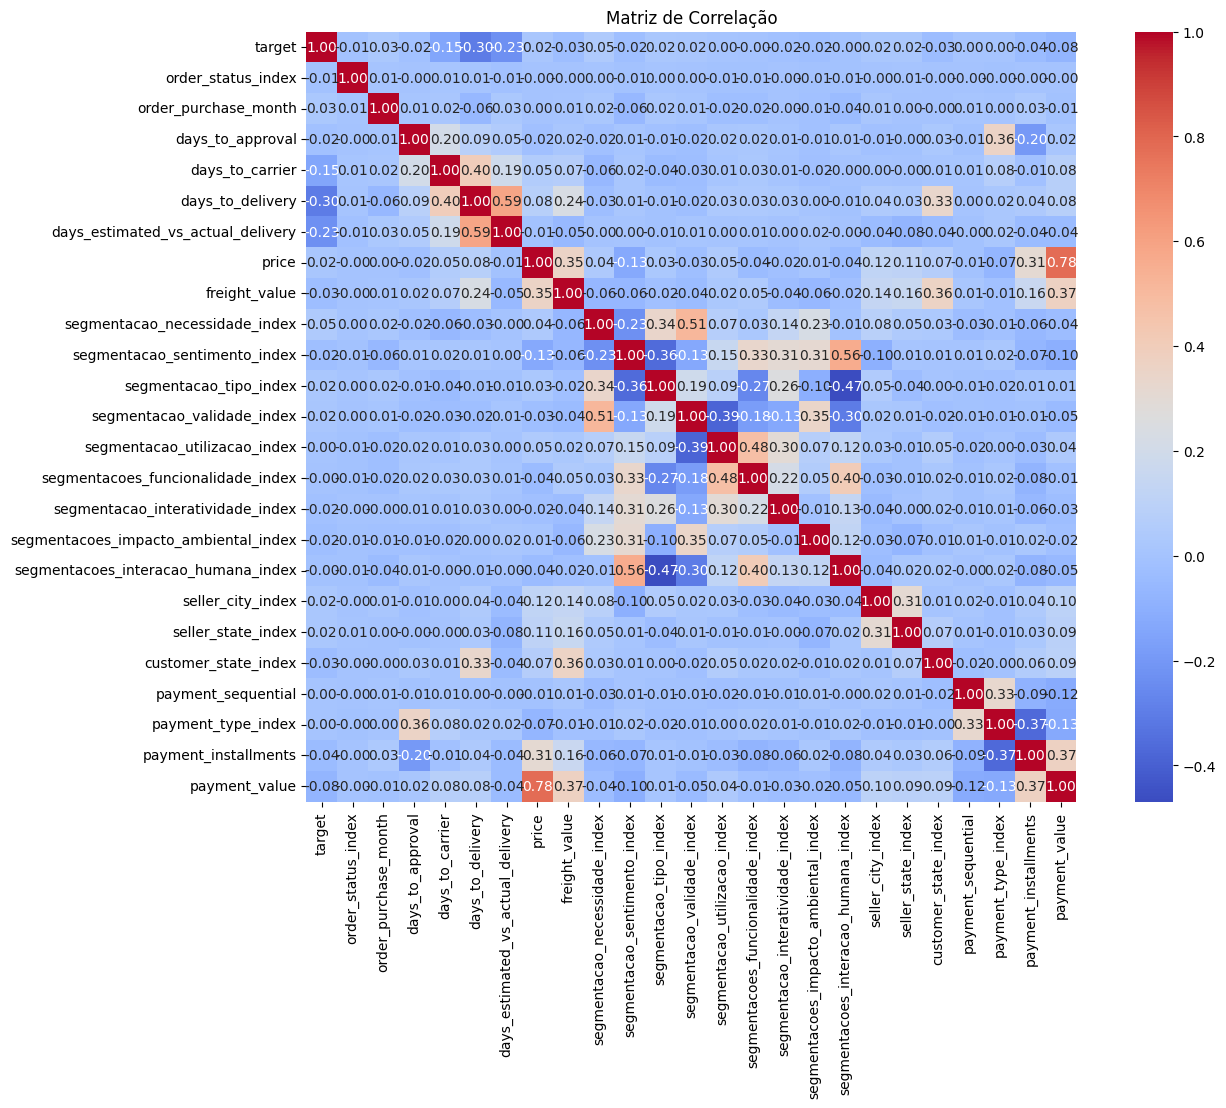

In [26]:
# Converter o DataFrame Spark para Pandas
df_pandas = df.toPandas()

# Calcular a matriz de correlação
correlation_matrix = df_pandas.corr()

# Configurar o tamanho da figura
plt.figure(figsize=(15, 10))

# Plotar a matriz de correlação usando seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Título do gráfico
plt.title('Matriz de Correlação')

# Exibir o gráfico
plt.show()


In [27]:

# Verificar valores nulos em cada coluna
null_values = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]).groupBy().sum()
null_values.show()

# Verificar número de linhas duplicadas
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Número de linhas duplicadas: {duplicate_count}")


+-----------+-----------------------+-------------------------+---------------------+--------------------+---------------------+--------------------------------------+----------+------------------+----------------------------------+---------------------------------+---------------------------+-------------------------------+---------------------------------+--------------------------------------+-------------------------------------+-----------------------------------------+----------------------------------------+----------------------+-----------------------+-------------------------+-----------------------+-----------------------+-------------------------+------------------+
|sum(target)|sum(order_status_index)|sum(order_purchase_month)|sum(days_to_approval)|sum(days_to_carrier)|sum(days_to_delivery)|sum(days_estimated_vs_actual_delivery)|sum(price)|sum(freight_value)|sum(segmentacao_necessidade_index)|sum(segmentacao_sentimento_index)|sum(segmentacao_tipo_index)|sum(segmentacao_val

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import plotly.express as px


# 1. Filtrar pedidos realizados entre setembro de 2016 e setembro de 2018
filtered_orders = orders.filter((F.col("order_purchase_timestamp") >= "2016-09-04") &
                                 (F.col("order_purchase_timestamp") <= "2018-09-03"))

# Filtrar pagamentos correspondentes aos pedidos filtrados
filtered_order_payments = order_payments.join(filtered_orders, on="order_id", how="inner")

# Filtrar avaliações correspondentes aos pedidos filtrados
filtered_order_reviews = order_reviews.join(filtered_orders, on="order_id", how="inner")

# Filtrar itens correspondentes aos pedidos filtrados
filtered_order_items = order_items.join(filtered_orders, on="order_id", how="inner")

filtered_orders = filtered_orders.withColumn("AnoMes", F.date_format("order_purchase_timestamp", "yyyy-MM"))

monthly_data = (
    filtered_order_payments.join(filtered_orders, on="order_id", how="inner")
    .join(filtered_order_reviews, on="order_id", how="inner")
    .join(filtered_order_items, on="order_id", how="inner")
    .join(products, on="product_id", how="inner")  # Juntando com a tabela products
    .join(product_category_name_translation,
          products.product_category_name == product_category_name_translation.product_category_name,
          how="inner")
    .groupBy("AnoMes", "product_category_name")
    .agg(F.sum("payment_value").alias("total_revenue"),
         F.countDistinct("order_id").alias("total_orders"),
         F.avg("review_score").alias("media_review_score"))
    .withColumn("ticket_medio", F.col("total_revenue") / F.col("total_orders"))
    .select("AnoMes", "product_category_name", "ticket_medio", "total_orders", "media_review_score")
)

# Coletar os dados em um DataFrame do Pandas
df_monthly_data = monthly_data.toPandas()

# 3. Calcular a variação percentual do ticket médio e da quantidade de pedidos
df_monthly_data['var_ticket_medio_percent'] = df_monthly_data['ticket_medio'].pct_change() * 100
df_monthly_data['var_total_orders_percent'] = df_monthly_data['total_orders'].pct_change() * 100

# Função para adicionar setas indicativas e formatação de variação percentual
def add_arrows_and_percent(data):
    arrow_data = data.copy()
    for i in range(1, data.shape[1]):
        for j in range(data.shape[0]):
            if data.iloc[j, i] > data.iloc[j, i-1]:
                arrow_data.iloc[j, i] = f"↑ {data.iloc[j, i]:.2f}%"
            elif data.iloc[j, i] < data.iloc[j, i-1]:
                arrow_data.iloc[j, i] = f"↓ {data.iloc[j, i]:.2f}%"
            else:
                arrow_data.iloc[j, i] = f"→ {data.iloc[j, i]:.2f}%"
    return arrow_data

# 4. Criar a matriz para a variação percentual do ticket médio
df_ticket_pivot = df_monthly_data.pivot(index='product_category_name', columns='AnoMes', values='var_ticket_medio_percent')
arrows_ticket = add_arrows_and_percent(df_ticket_pivot)

# Criar o gráfico interativo como um mapa de calor para o ticket médio
fig_ticket_heatmap = px.imshow(df_ticket_pivot, color_continuous_scale='RdBu_r', aspect='auto')

# Adicionar anotações com setas para a variação do ticket médio
annotations_ticket = []
for i in range(len(df_ticket_pivot.index)):
    for j in range(len(df_ticket_pivot.columns)):
        value_text = arrows_ticket.iat[i, j]
        annotations_ticket.append(dict(
            x=df_ticket_pivot.columns[j],
            y=df_ticket_pivot.index[i],
            text=value_text,
            showarrow=False,
            font=dict(size=12)
        ))

fig_ticket_heatmap.update_layout(annotations=annotations_ticket)
fig_ticket_heatmap.update_layout(
    title=dict(text="Variação Percentual do Ticket Médio por Categoria de Produto", font=dict(size=20)),
    xaxis_title='Ano-Mês',
    yaxis_title='Categoria do Produto'
)

fig_ticket_heatmap.show()

# 5. Criar a matriz para a variação percentual da quantidade de pedidos
df_orders_pivot = df_monthly_data.pivot(index='product_category_name', columns='AnoMes', values='var_total_orders_percent')
arrows_orders = add_arrows_and_percent(df_orders_pivot)

# Criar o gráfico interativo como um mapa de calor para a quantidade de pedidos
fig_orders_heatmap = px.imshow(df_orders_pivot, color_continuous_scale='RdBu_r', aspect='auto')

# Adicionar anotações com setas para a variação da quantidade de pedidos
annotations_orders = []
for i in range(len(df_orders_pivot.index)):
    for j in range(len(df_orders_pivot.columns)):
        value_text = arrows_orders.iat[i, j]
        annotations_orders.append(dict(
            x=df_orders_pivot.columns[j],
            y=df_orders_pivot.index[i],
            text=value_text,
            showarrow=False,
            font=dict(size=12)
        ))

fig_orders_heatmap.update_layout(annotations=annotations_orders)
fig_orders_heatmap.update_layout(
    title=dict(text="Variação Percentual da Quantidade de Pedidos por Categoria de Produto", font=dict(size=20)),
    xaxis_title='Ano-Mês',
    yaxis_title='Categoria do Produto'
)

fig_orders_heatmap.show()

AnalysisException: Column product_category_name#128 are ambiguous. It's probably because you joined several Datasets together, and some of these Datasets are the same. This column points to one of the Datasets but Spark is unable to figure out which one. Please alias the Datasets with different names via `Dataset.as` before joining them, and specify the column using qualified name, e.g. `df.as("a").join(df.as("b"), $"a.id" > $"b.id")`. You can also set spark.sql.analyzer.failAmbiguousSelfJoin to false to disable this check.

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Supondo que o DataFrame de pedidos se chama df_orders
# Agrupando por data e contando as vendas
vendas_por_data = orders.groupBy(F.to_date("order_purchase_timestamp").alias("data")) \
                            .agg(F.count("order_id").alias("quantidade_vendas")) \
                            .filter((F.to_date("data") >= "2016-09-04") & (F.to_date("data") <= "2018-09-03")) \
                            .orderBy("data")

# Convertendo para Pandas para plotagem
vendas_por_data_pd = vendas_por_data.toPandas()

# Criando o gráfico de linha
plt.figure(figsize=(18, 6))
plt.plot(vendas_por_data_pd['data'], vendas_por_data_pd['quantidade_vendas'], marker='o')
plt.title('Quantidade de Vendas por Data (2016-09-04 a 2018-09-03)')
plt.xlabel('Data')
plt.ylabel('Quantidade de Vendas')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Realizando um join entre os pedidos e os itens do pedido
df_joined = orders.join(order_items, on="order_id", how="inner")

# Agrupando por data e somando o faturamento
faturamento_por_data = df_joined.groupBy(F.to_date("order_purchase_timestamp").alias("data")) \
                                 .agg(F.sum("price").alias("faturamento_total")) \
                                 .filter((F.to_date("data") >= "2016-09-04") & (F.to_date("data") <= "2018-09-03")) \
                                 .orderBy("data")

# Convertendo para Pandas para plotagem
faturamento_por_data_pd = faturamento_por_data.toPandas()

# Criando o gráfico de linha
plt.figure(figsize=(18, 6))
plt.plot(faturamento_por_data_pd['data'], faturamento_por_data_pd['faturamento_total'], color='orange', marker='o')
plt.title('Faturamento Total por Data (2016-09-04 a 2018-09-03)')
plt.xlabel('Data')
plt.ylabel('Faturamento Total (R$)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Importando bibliotecas necessárias
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps

# Juntando as tabelas necessárias
merged_df = (order_reviews
              .join(orders, "order_id")  # Juntando order_reviews com orders
              .join(order_items, "order_id")  # Juntando com order_items
              .join(products, "product_id")  # Juntando com products
              .join(product_category_name_translation,
                     products.product_category_name == product_category_name_translation.product_category_name,
                     "inner")  # Juntando com product_category_name_translation usando a coluna de categoria
)

# Convertendo a coluna de data para datetime e extraindo o trimestre
merged_df = merged_df.withColumn("order_purchase_timestamp", merged_df["order_purchase_timestamp"].cast("timestamp")) \
                      .withColumn("quarter", (F.month(merged_df["order_purchase_timestamp"]) - 1) / 3 + 1)

# Agrupando por categoria e trimestre para calcular a média de satisfação
performance_matrix = merged_df.groupBy("product_category_name_english", "quarter") \
    .agg(F.avg("review_score").alias("average_review_score"))

# Transformando os dados em formato matricial
performance_matrix_pivot = performance_matrix.groupBy("product_category_name_english") \
    .pivot("quarter") \
    .agg(F.first("average_review_score")) \
    .na.fill(0)  # Preenchendo valores nulos com zero

# Convertendo para Pandas DataFrame para visualização
performance_matrix_pd = performance_matrix_pivot.toPandas()

# Criar uma matriz intercalada para visualização
performance_matrix_intercalated = []
for index, row in performance_matrix_pd.iterrows():
    intercalated_row = [index]  # Começa com o nome da categoria
    for quarter in range(1, 5):
        intercalated_row.append(row.get(quarter, 0))  # Adiciona a média ou zero se não existir
    performance_matrix_intercalated.append(intercalated_row)

# Criar um DataFrame do Pandas para visualização final
intercalated_df = pd.DataFrame(performance_matrix_intercalated, columns=["Categoria", "Q1", "Q2", "Q3", "Q4"])

# Exibindo a matriz intercalada
print(intercalated_df)

# Plotando a matriz
plt.figure(figsize=(12, 6))
intercalated_df.set_index('Categoria').plot(kind='bar', ax=plt.gca())
plt.title('Média de Satisfação por Categoria ao Longo dos Trimestres')
plt.xlabel('Categoria de Produto')
plt.ylabel('Média de Satisfação')
plt.xticks(rotation=45)
plt.legend(title='Trimestre')
plt.tight_layout()
plt.show()

In [ ]:
# Verificar valores nulos em cada coluna
null_values = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]).groupBy().sum()

# Mostrar os valores nulos de forma mais clara
null_values_df = null_values.toPandas().transpose().reset_index()
null_values_df.columns = ['Column', 'Null Values']
print(null_values_df)

# Visualizar os valores nulos
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar o tamanho da figura
plt.figure(figsize=(15, 10))

# Plotar os valores nulos usando seaborn
sns.barplot(x='Null Values', y='Column', data=null_values_df)
plt.title('Valores Nulos por Coluna')
plt.show()


In [ ]:
# Definir o caminho do arquivo CSV no Databricks File System (DBFS)
output_path = "/dbfs/tmp/df_output.csv"

# Exportar o DataFrame para CSV
df.write.csv(output_path, header=True)

print(f"DataFrame exportado com sucesso para {output_path}")


In [ ]:

# Salva o DataFrame atualizado em um novo caminho com o mesmo nome ou um novo nome
product_category_name_translation.write.mode('overwrite').csv('dbfs:/FileStore/tables/ecommerce/product_category_name_translation_atualizado.csv', header=True)

# Verifica o novo arquivo criado
display(dbutils.fs.ls('dbfs:/FileStore/tables/ecommerce/'))


In [ ]:
display(dbutils.fs.ls("dbfs:/FileStore/tables/ecommerce/"))

In [ ]:
# Carregar o arquivo CSV atualizado
product_category_name_translation_atualizado = spark.read.csv('dbfs:/FileStore/tables/ecommerce/product_category_name_translation_atualizado.csv', header=True, inferSchema=True)
# Exibir as primeiras linhas do DataFrame atualizado
product_category_name_translation_atualizado.show()


In [ ]:
# Salva o DataFrame atualizado em um novo diretório no DBFS
product_category_name_translation.write.mode('overwrite').option('header', True).csv('dbfs:/FileStore/shared_uploads/product_category_name_translation_atualizado')

# Gerar link de download para o primeiro arquivo CSV particionado
files = dbutils.fs.ls('dbfs:/FileStore/shared_uploads/product_category_name_translation_atualizado')
for file in files:
    if file.path.endswith(".csv"):
        download_link = file.path.replace('dbfs:/', '/files/')
        break
displayHTML(f"<a href='{download_link}' download>Baixar Arquivo Atualizado</a>")


In [ ]:
print("Arquivos gerados:")
display(dbutils.fs.ls("dbfs:/FileStore/tables/ecommerce/"))

In [ ]:
print("Arquivos gerados:")
display(dbutils.fs.ls("dbfs:/FileStore/tables/ecommerce/"))